### Problem 1

To show that the derived closed-form expression $g(i)=\Psi_i^T\left( I-M\text(diag)(V_*)\right)^{-1}MV_+$ is accurate, we will randomly generate a 100 graphs and compare the calcuated probability with the observed probability via monte carlos simulations (1 million trials).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as progress

In [11]:
def directcalc(M,i,v_plus,v_null,limit=20):
    M_null = np.dot(M,np.diag(v_null.flatten()))
    A = np.linalg.inv(np.eye(M.shape[0]) - M_null)
    B = np.dot(M,v_plus)
    C = i.reshape(1,len(i))
    return np.dot(C,np.dot(A,B))

In [12]:
def getRandomM(N=100,discrete=True):
    if discrete:
        m1 = (np.random.random((N,N)) < 0.5).astype(np.float64)
    else:
        m1 = np.random.random((N,N))
    M_ = np.triu(m1,1)
    M_ = M_ + M_.T
    M = np.dot(np.diag(np.divide(1,np.sum(M_,axis=1))),M_)
    selection_M = np.cumsum(M,axis=1)
    return M, selection_M

In [13]:
def defineParitions(N=100):
    p1_limit = int(N/3)
    p2_limit = p1_limit * 2
    partitions = np.zeros(N)
    partitions[p1_limit:p2_limit] = 1
    partitions[p2_limit:] = 2
    return partitions

In [14]:
def getNewPosition(i,selection_M):
    r = np.random.random()
    choices = selection_M[i,:]
    j = np.where(choices > r)[0][0]
    return j

In [20]:
def montecarlo(selection_M,partition,trials=10000):
    success = 0.0
    failure = 0.0
    
    for x in progress(range(trials)):
        i=0
        while partition[i] == 0:
            i = getNewPosition(i,selection_M)
        if partition[i] == 1:
            failure = failure + 1
        else:
            success = success + 1
    return success/trials, failure/trials

In [24]:
def compare(discrete=True,trials=10000,size=10):
    partitions= defineParitions(N=size)
    v_null = (partitions == 0).astype(int).reshape(len(partitions),1)
    v_plus = (partitions == 2).astype(int).reshape(len(partitions),1)
    i = np.zeros(len(partitions))
    i[0] = 1
    
    M, selection_M = getRandomM(N=size,discrete=discrete)
    
    direct_prob = directcalc(M,i,v_plus,v_null)
    mc_success,_ = montecarlo(selection_M,partitions,trials=trials)
    return direct_prob, mc_success

In [27]:
samples = 100
errors = []
for x in progress(range(samples)):
    dp,mc = compare(trials=1000000,discrete=False,size=20)
    errors.append(dp-mc)

Mean: -0.0001
Std:  0.0005


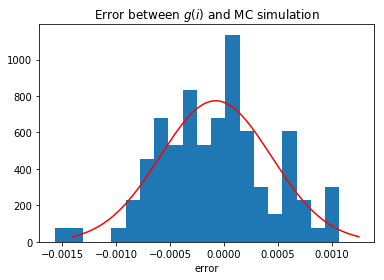

In [38]:
from scipy.stats import norm
errs = [e[0][0] for e in errors]
m = np.mean(errs)
print('Mean: %.4f'%m)
print('Std:  %.4f'%std)
std = np.std(errs)
I = norm.interval(0.99,loc=m,scale=std)
x = np.linspace(I[0],I[1],1000)
y = norm.pdf(x,loc=m,scale=std)
plt.hist(errs,bins=20,density=True)
plt.plot(x,y,c='r')
plt.xlabel('error')
plt.title('Error between $g(i)$ and MC simulation')
plt.show()

The experimental results differ from the calculated $g(i)$ by 0.0001 on average with a standard deviation of 0.005. This 